In [2]:
project_name = 'weather-dataset'

In [3]:
# jovian.commit(project=project_name, environment=None)

# Multi-class Weather Dataset for Image Classification

## Description
Multi-class weather dataset(MWD) for image classification is a valuable dataset used in the research paper entitled “Multi-class weather recognition from still image using heterogeneous ensemble method”. The dataset provides a platform for outdoor weather analysis by extracting various features for recognizing different weather conditions. 

This dataset is a collection of 1125 images divided into four categories. The image categories are sunrise, shine, rain, and cloudy. 

In [4]:
# Importing and extracting the dataset
from torchvision.datasets.utils import download_url

dataset_url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip'
download_url(dataset_url, '.')

import zipfile
with zipfile.ZipFile('/content/4drtyfjtfy-1.zip', 'r') as zip_ref:
    zip_ref.extractall(path='.')

with zipfile.ZipFile('/content/dataset2.zip', 'r') as zip_ref:
    zip_ref.extractall(path='./data')

Using downloaded and verified file: ./4drtyfjtfy-1.zip


In [5]:
import os
DATA_DIR = './data'
print(os.listdir(DATA_DIR))

['dataset2']


In [6]:
DATASET_PATH = DATA_DIR + '/dataset2'
print('Number of training examples: ', len(os.listdir(DATASET_PATH)))
print(os.listdir(DATASET_PATH)[:5])

Number of training examples:  1125
['sunrise95.jpg', 'sunrise79.jpg', 'rain27.jpg', 'rain167.jpg', 'cloudy106.jpg']


In [7]:
import re
files = os.listdir(DATASET_PATH)

def parse_names(fname):
  name = re.split('[0-9]', fname)
  return name[0]

In [8]:
parse_names(files[55])

'rain'

In [9]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

## Creating a Dataset

In [10]:
from torch.utils.data import Dataset

class WeatherDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root = root
    self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
    self.classes = list(set(parse_names(fname) for fname in files))
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    fname = self.files[i]
    fpath = os.path.join(self.root, fname)
    img = self.transform(open_image(fpath))
    class_idx = self.classes.index(parse_names(fname))
    return img, class_idx

In [11]:
import torchvision.transforms as T

img_size = 64
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = WeatherDataset(DATASET_PATH, transform=T.Compose([T.Resize(img_size),
                                              T.Pad(8, padding_mode='reflect'),
                                              T.RandomCrop(img_size),
                                              T.ToTensor(),
                                              T.Normalize(*stats)]))

In [12]:
len(dataset)

1122

In [13]:
dataset.classes

['shine', 'sunrise', 'rain', 'cloudy']

In [14]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: cloudy (3)


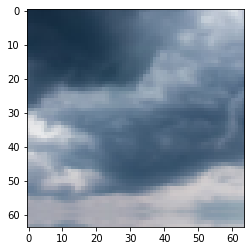

In [15]:
show_image(*dataset[12])

## Creating Training and Validation Sets

In [16]:
from torch.utils.data import random_split

random_seed = 42
torch.manual_seed(random_seed);

val_pct = 0.15
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])
len(train_ds), len(valid_ds)

(954, 168)

In [17]:
jovian.log_dataset(dataset_url=dataset_url, val_size=val_size, random_seed=random_seed)

[jovian] Dataset logged.


In [18]:
from torch.utils.data import DataLoader

batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    images = denormalize(images[:16], *stats)
    ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


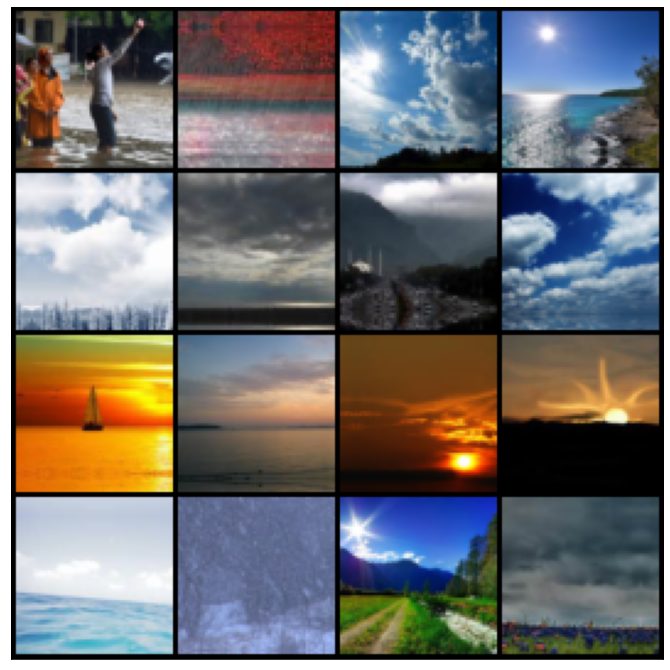

In [20]:
show_batch(train_dl)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [23]:
class WeatherCNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input 3 x 64 x 64
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.ReLU(),
            # output 32 x 64 x 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # output 64 x 64 x 64
            nn.MaxPool2d(2, 2), 
            # output: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 8 x 8

            nn.Flatten(), 
            nn.Linear(512*8*8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4))
        
    def forward(self, xb):
        return self.network(xb)

In [24]:
model = WeatherCNNModel()
model

WeatherCNNModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=32768, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [25]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([32, 3, 64, 64])
out.shape: torch.Size([32, 4])
out[0]: tensor([ 0.0076,  0.0004, -0.0383,  0.0423], grad_fn=<SelectBackward>)


In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
model = to_device(model, device);

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
evaluate(model, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.1666666716337204, 'val_loss': 1.3897231817245483}

In [31]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.001

In [32]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [33]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.0121, val_loss: 0.4745, val_acc: 0.8177
Epoch [1], train_loss: 0.6874, val_loss: 0.4662, val_acc: 0.8073
Epoch [2], train_loss: 0.6282, val_loss: 0.5387, val_acc: 0.6979
Epoch [3], train_loss: 0.6097, val_loss: 0.4521, val_acc: 0.8229
Epoch [4], train_loss: 0.5425, val_loss: 0.3803, val_acc: 0.8646
Epoch [5], train_loss: 0.4501, val_loss: 0.4850, val_acc: 0.7760
Epoch [6], train_loss: 0.4789, val_loss: 0.3972, val_acc: 0.8490
Epoch [7], train_loss: 0.4085, val_loss: 0.3302, val_acc: 0.8750
Epoch [8], train_loss: 0.4292, val_loss: 0.3781, val_acc: 0.8698
Epoch [9], train_loss: 0.3999, val_loss: 0.2896, val_acc: 0.8906
Epoch [10], train_loss: 0.3822, val_loss: 0.2644, val_acc: 0.9115
Epoch [11], train_loss: 0.3203, val_loss: 0.2855, val_acc: 0.9219
Epoch [12], train_loss: 0.3868, val_loss: 0.9083, val_acc: 0.7500
Epoch [13], train_loss: 0.4740, val_loss: 0.3125, val_acc: 0.8854
Epoch [14], train_loss: 0.4170, val_loss: 0.3068, val_acc: 0.8958
Epoch [15], train_lo

In [34]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

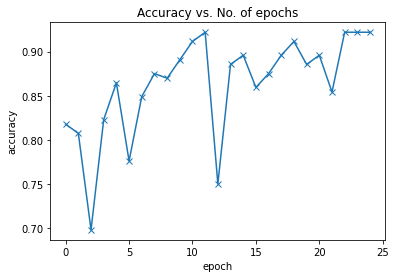

In [36]:
plot_accuracies(history)

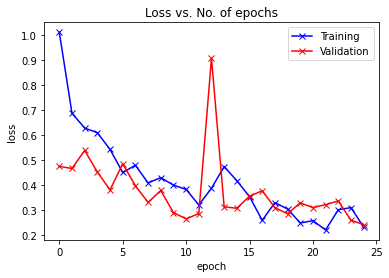

In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [38]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/ibrahimvid/weather-dataset


'https://jovian.ai/ibrahimvid/weather-dataset'

In [39]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [48]:
def show_prediction(img, label):
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
  plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: shine , Predicted: rain


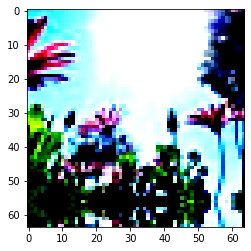

In [49]:
show_prediction(*valid_ds[18])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: sunrise , Predicted: sunrise


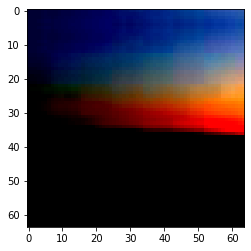

In [50]:
show_prediction(*valid_ds[29])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cloudy , Predicted: cloudy


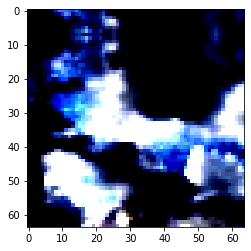

In [51]:
show_prediction(*valid_ds[77])